# Predictive Customer Relationship Management using Graph-Deep Learning

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation
import mxnet.ndarray as nd
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
from numpy import array
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.ndarray import sum as ndsum

In [3]:
# Read data from file 'filename.csv' 
data_node = pd.read_csv("crm.attributes.csv") 
# Preview the first 5 lines of the loaded data 
print(data_node.head())

   node churn status
0     0   Won    Won
1     1  Sale    Won
2     2  Sale    Won
3     3  Sale    Won
4     4  Sale    Won


In [4]:
df_admin=data_node.loc[data_node['status'] == 'Won', 'node']
print(df_admin.head())

0    0
1    1
2    2
3    3
4    4
Name: node, dtype: int64


In [5]:
#list(df_admin.columns)
len(df_admin)

177

## Data Preparation

In [6]:
DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)

def load_crm_data():
    network = read_edgelist(
        'crm.edgelist',
        nodetype=int)

    attributes = read_csv(
        'crm.attributes.csv',
        index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(
                attributes[attribute],
                index=attributes.index).to_dict(),
            name=attribute
        )

    X_train, y_train = map(array, zip(*[
        ([node], data['churn'] == 'Won')
        for node, data in network.nodes(data=True)
        if data['churn'] in {'Won', 'Lost'}
    ]))
    X_test, y_test = map(array, zip(*[
        ([node], data['status'] == 'Won')
        for node, data in network.nodes(data=True)
        if data['churn'] == 'Sale'
    ]))
    
    return DataSet(
        X_train, y_train,
        X_test, y_test,
        network)

In [8]:
X_train

array([ 0, 96])

In [9]:
X_test

array([ 15,  16,  17,  18,  19,  20, 197, 198, 199, 200,   9, 201,  60,
        61,   3,   2,   1,   4, 202, 203, 204,   6,   5,   7,   8,  11,
        12,  14,  13,  10, 205, 206,  23,  24,  25, 207,  21,  22,  26,
        27,  28,  29,  30, 208, 209, 210,  31, 211, 212, 213,  32,  33,
        34,  35,  36, 214, 215, 216,  37,  38,  39,  40,  41,  42, 217,
        43,  44,  45, 218, 219, 220, 221, 222, 223,  46,  47,  48,  49,
        50,  94,  95, 224,  51,  52,  53, 225,  56, 226, 227,  54,  55,
       228, 229, 230, 231, 232,  57,  58,  59, 233, 234, 235, 236, 237,
        68,  69,  70,  62,  63,  64,  65,  66,  67,  71,  72,  73, 238,
       239, 240, 241, 242, 243, 244, 245,  74,  75,  76,  77,  78,  79,
       246, 247, 248, 249, 250, 251, 252,  80,  81,  82,  83, 253, 254,
       255, 256, 257, 258, 259, 260, 261, 262,  84,  85,  88,  86,  87,
        89,  90,  91,  92,  93, 263, 264, 265, 266, 267,  97, 268, 101,
       102, 103, 104, 269, 132, 133, 134, 270, 271,  98,  99, 10

# Layer Implementations

In [10]:
class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        aggregate = F.dot(A_hat, X)
        propagate = self.activation(
            F.dot(aggregate, W))
        return propagate
    
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )

            self.b = self.params.get(
                'b', shape=(1, 1)
            )

    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(367, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)

# Train and Test Models - definition

In [13]:
def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(hidden_layer_specs):
            layer = SpectralRule(
                A, in_units=in_units, out_units=layer_size, 
                activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units

def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    model.hybridize()
    model.initialize(Uniform(1))

    return model, features

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.01, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        if (e % (epochs//10)) == 0:
            print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
            print(cum_preds)
    return feature_representations

def predict(model, X, nodes):
    preds = model(X)[nodes].asnumpy().flatten()
    return np.where(preds >= 0.5, 1, 0)

Wall time: 0 ns


## Model 1: Identity Matrix as Features

In [147]:
X_1 = I = nd.eye(*A.shape)
X_1


[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
<NDArray 367x367 @cpu(0)>

In [149]:
from sklearn.metrics import classification_report
model_1, features_1 = build_model(A, X_1)
feature_representations_1 = train(model_1, features_1, X_1, X_train, y_train, epochs=800)
y_pred_1 = predict(model_1, X_1, X_test)

Epoch 80/800 -- Loss:  1.2447
[0.5315915, 0.458182]
Epoch 160/800 -- Loss:  0.5193
[0.6944782, 0.14332318]
Epoch 240/800 -- Loss:  0.0860
[0.9522248, 0.036353655]
Epoch 320/800 -- Loss:  0.0117
[0.99592006, 0.007619649]
Epoch 400/800 -- Loss:  0.0015
[0.99965227, 0.0011989515]
Epoch 480/800 -- Loss:  0.0002
[0.9999701, 0.00017732363]
Epoch 560/800 -- Loss:  0.0000
[0.9999974, 2.606136e-05]
Epoch 640/800 -- Loss:  0.0000
[0.99999976, 3.833709e-06]
Epoch 720/800 -- Loss:  0.0000
[1.0, 5.645105e-07]
Epoch 800/800 -- Loss:  0.0000
[1.0, 8.3163926e-08]


In [150]:
print(confusion_matrix(y_test, y_pred_1))
print(classification_report(y_test, y_pred_1))
print(accuracy_score(y_test, y_pred_1))

[[ 61 128]
 [ 58 118]]
              precision    recall  f1-score   support

       False       0.51      0.32      0.40       189
        True       0.48      0.67      0.56       176

    accuracy                           0.49       365
   macro avg       0.50      0.50      0.48       365
weighted avg       0.50      0.49      0.47       365

0.4904109589041096


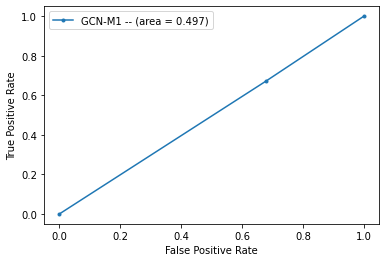

In [374]:
m1_fpr, m1_tpr, _ = roc_curve(y_test, y_pred_1)
roc_auc_m1 = roc_auc_score(y_test, y_pred_1)
# plot the roc curve for the model
#pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

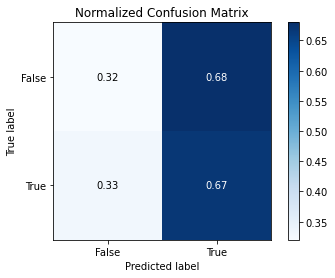

In [155]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_pred_1, normalize=True)
plt.show()

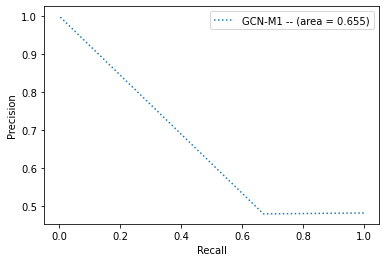

In [375]:
m1_pr, m1_re, thresholds = precision_recall_curve(y_test,y_pred_1)
pr_auc_m1=auc(m1_re, m1_pr)
pyplot.plot(m1_re, m1_pr, linestyle=':', label='GCN-M1 -- (area = %0.3f)' % pr_auc_m1)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Model 2: Distance to Sales-Won node and Lost Node as Additional Features

In [110]:
X_2 = nd.zeros((A.shape[0], 2))

In [111]:
node_distance_instructor = shortest_path_length(crm.network, target=96)
node_distance_administrator = shortest_path_length(crm.network, target=0)

In [112]:
for node in crm.network.nodes():
    X_2[node][0] = node_distance_administrator[node]
    X_2[node][1] = node_distance_instructor[node]

In [114]:
model_2, features_2 = build_model(A, X_2)
feature_representations_2= train(model_2, features_2, X_2, X_train, y_train, epochs=500)
y_pred_2 = predict(model_2, X_2, X_test)
#print(classification_report(y_test, y_pred_2))

Epoch 50/500 -- Loss:  1.2678
[0.5064469, 0.4442595]
Epoch 100/500 -- Loss:  0.6665
[0.6507229, 0.21090318]
Epoch 150/500 -- Loss:  0.1799
[0.85967886, 0.028330464]
Epoch 200/500 -- Loss:  0.0322
[0.97271395, 0.0045138234]
Epoch 250/500 -- Loss:  0.0048
[0.99605393, 0.0008081105]
Epoch 300/500 -- Loss:  0.0007
[0.9994943, 0.00014695163]
Epoch 350/500 -- Loss:  0.0001
[0.9999418, 2.675045e-05]
Epoch 400/500 -- Loss:  0.0000
[0.99999416, 4.8690126e-06]
Epoch 450/500 -- Loss:  0.0000
[0.9999995, 8.861536e-07]
Epoch 500/500 -- Loss:  0.0000
[1.0, 1.6126621e-07]


In [115]:
print(confusion_matrix(y_test, y_pred_2))
print(classification_report(y_test, y_pred_2))
print(accuracy_score(y_test, y_pred_2))

[[189   0]
 [ 22 154]]
              precision    recall  f1-score   support

       False       0.90      1.00      0.95       189
        True       1.00      0.88      0.93       176

    accuracy                           0.94       365
   macro avg       0.95      0.94      0.94       365
weighted avg       0.95      0.94      0.94       365

0.9397260273972603


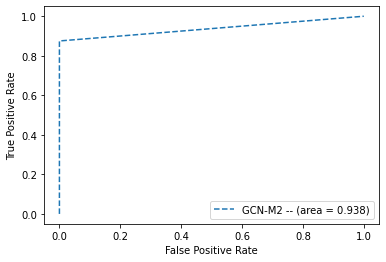

In [157]:
m2_fpr, m2_tpr, _ = roc_curve(y_test, y_pred_2)
roc_auc_m2 = roc_auc_score(y_test, y_pred_2)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m2_fpr, m2_tpr, linestyle='--', label='GCN-M2 -- (area = %0.3f)' % roc_auc_m2)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

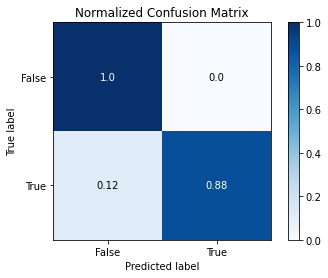

In [158]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_pred_2, normalize=True)
plt.show()

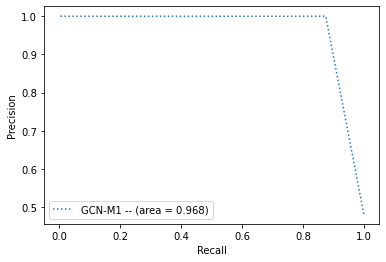

In [376]:
m2_pr, m2_re, thresholds = precision_recall_curve(y_test,y_pred_2)
pr_auc_m2=auc(m2_re, m2_pr)
pyplot.plot(m2_re, m2_pr, linestyle=':', label='GCN-M1 -- (area = %0.3f)' % pr_auc_m2)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Model-4 --- eigenvector_centrality

In [159]:
from networkx import eigenvector_centrality, eigenvector_centrality_numpy
node_eigenvector_centrality = eigenvector_centrality(crm.network)
node_eigenvector_centrality_numpy=eigenvector_centrality_numpy(crm.network)

In [161]:
X_4 = nd.zeros((A.shape[0], 2))
for node in crm.network.nodes():
    X_4[node][0] = node_eigenvector_centrality[node]
    X_4[node][1] = node_eigenvector_centrality_numpy[node]
model_4, features_4 = build_model(A, X_4)
feature_representations_4= train(model_4, features_4, X_4, X_train, y_train, epochs=5000)
y_pred_4 = predict(model_4, X_4, X_test)
print(classification_report(y_test, y_pred_4))

Epoch 500/5000 -- Loss:  1.5931
[0.71455973, 0.7154965]
Epoch 1000/5000 -- Loss:  1.5236
[0.3189839, 0.31679216]
Epoch 1500/5000 -- Loss:  1.4580
[0.6260469, 0.628289]
Epoch 2000/5000 -- Loss:  1.3835
[0.4498115, 0.44263336]
Epoch 2500/5000 -- Loss:  1.3434
[0.48358312, 0.46037868]
Epoch 3000/5000 -- Loss:  0.7178
[0.84426314, 0.42219484]
Epoch 3500/5000 -- Loss:  0.0024
[1.0, 0.0023519346]
Epoch 4000/5000 -- Loss:  0.0000
[1.0, 9.835709e-07]
Epoch 4500/5000 -- Loss:  0.0000
[1.0, 5.5008353e-09]
Epoch 5000/5000 -- Loss:  0.0000
[1.0, 1.0975304e-09]
              precision    recall  f1-score   support

       False       0.79      0.97      0.87       189
        True       0.96      0.73      0.83       176

    accuracy                           0.85       365
   macro avg       0.88      0.85      0.85       365
weighted avg       0.87      0.85      0.85       365



In [162]:
print(confusion_matrix(y_test, y_pred_4))

[[184   5]
 [ 48 128]]


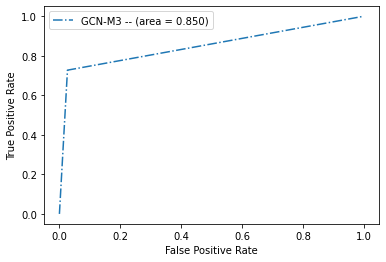

In [167]:
m3_fpr, m3_tpr, _ = roc_curve(y_test, y_pred_4)
roc_auc_m3 = roc_auc_score(y_test, y_pred_4)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m3_fpr, m3_tpr, linestyle='-.', label='GCN-M3 -- (area = %0.3f)' % roc_auc_m3)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

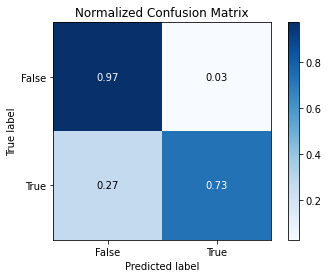

In [168]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_pred_4, normalize=True)
plt.show()

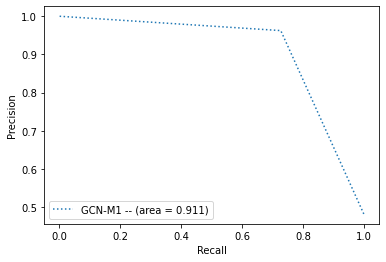

In [377]:
m3_pr, m3_re, thresholds = precision_recall_curve(y_test,y_pred_4)
pr_auc_m3=auc(m3_re, m3_pr)
pyplot.plot(m3_re, m3_pr, linestyle=':', label='GCN-M1 -- (area = %0.3f)' % pr_auc_m3)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Model- 5  ---- closeness_centrality

In [188]:
from networkx import closeness_centrality, current_flow_closeness_centrality,betweenness_centrality
node_closeness_centrality=closeness_centrality(crm.network)
node_betweenness_centrality=betweenness_centrality(crm.network)

In [190]:
X_5 = nd.zeros((A.shape[0], 2))
for node in crm.network.nodes():
    X_5[node][0] = node_closeness_centrality[node]
    X_5[node][1] = node_betweenness_centrality[node]
model_5, features_5 = build_model(A, X_5)
feature_representations_5= train(model_5, features_5, X_5, X_train, y_train, epochs=1000)
y_pred_5 = predict(model_5, X_5, X_test)
print(classification_report(y_test, y_pred_5))

Epoch 100/1000 -- Loss:  1.4007
[0.6739793, 0.6343837]
Epoch 200/1000 -- Loss:  0.7854
[0.4965829, 0.08185702]
Epoch 300/1000 -- Loss:  0.0351
[0.9805085, 0.015302661]
Epoch 400/1000 -- Loss:  0.0076
[0.9998172, 0.0073672137]
Epoch 500/1000 -- Loss:  0.0036
[0.9999974, 0.0036026496]
Epoch 600/1000 -- Loss:  0.0015
[1.0, 0.0015445137]
Epoch 700/1000 -- Loss:  0.0006
[1.0, 0.00060553616]
Epoch 800/1000 -- Loss:  0.0002
[1.0, 0.00022836118]
Epoch 900/1000 -- Loss:  0.0001
[1.0, 8.4835956e-05]
Epoch 1000/1000 -- Loss:  0.0000
[1.0, 3.1342435e-05]
              precision    recall  f1-score   support

       False       0.53      0.95      0.68       189
        True       0.67      0.11      0.19       176

    accuracy                           0.55       365
   macro avg       0.60      0.53      0.44       365
weighted avg       0.60      0.55      0.45       365



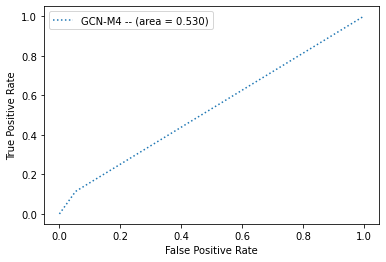

In [191]:
m4_fpr, m4_tpr, _ = roc_curve(y_test, y_pred_5)
roc_auc_m4 = roc_auc_score(y_test, y_pred_5)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m4_fpr, m4_tpr, linestyle=':', label='GCN-M4 -- (area = %0.3f)' % roc_auc_m4)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

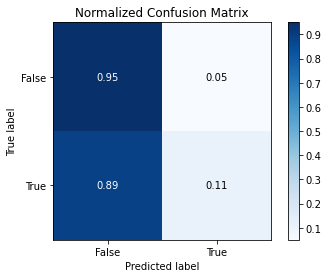

In [192]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_pred_5, normalize=True)
plt.show()

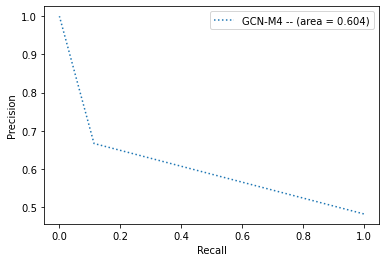

In [378]:
m4_pr, m4_re, thresholds = precision_recall_curve(y_test,y_pred_5)
pr_auc_m4=auc(m4_re, m4_pr)
pyplot.plot(m4_re, m4_pr, linestyle=':', label='GCN-M4 -- (area = %0.3f)' % pr_auc_m4)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Model -8

In [196]:
from networkx import clustering, square_clustering, generalized_degree
node_clustering=clustering(crm.network)

In [198]:
X_8 = nd.zeros((A.shape[0], 1))
for node in crm.network.nodes():
    X_8[node][0] = node_clustering[node]
model_8, features_8 = build_model(A, X_8)
feature_representations_8= train(model_8, features_8, X_8, X_train, y_train, epochs=20000)
y_pred_8 = predict(model_8, X_8, X_test)
print(classification_report(y_test, y_pred_8))

Epoch 2000/20000 -- Loss:  1.4488
[0.3734846, 0.37118733]
Epoch 4000/20000 -- Loss:  1.3892
[0.5490291, 0.5459538]
Epoch 6000/20000 -- Loss:  1.5232
[0.6809892, 0.6798515]
Epoch 8000/20000 -- Loss:  1.5259
[0.6780595, 0.6793385]
Epoch 10000/20000 -- Loss:  1.4001
[0.5414492, 0.5446097]
Epoch 12000/20000 -- Loss:  1.4620
[0.36794275, 0.37011227]
Epoch 14000/20000 -- Loss:  1.5530
[0.3033031, 0.3023224]
Epoch 16000/20000 -- Loss:  1.4195
[0.3840328, 0.37025693]
Epoch 18000/20000 -- Loss:  0.7045
[0.8659352, 0.42911202]
Epoch 20000/20000 -- Loss:  0.0000
[1.0, 6.6005174e-11]
              precision    recall  f1-score   support

       False       0.56      1.00      0.72       189
        True       1.00      0.16      0.28       176

    accuracy                           0.60       365
   macro avg       0.78      0.58      0.50       365
weighted avg       0.77      0.60      0.51       365



In [199]:
print(confusion_matrix(y_test, y_pred_8))

[[189   0]
 [147  29]]


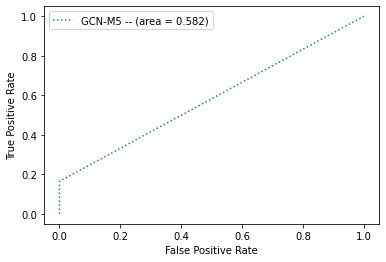

In [200]:
m5_fpr, m5_tpr, _ = roc_curve(y_test, y_pred_8)
roc_auc_m5 = roc_auc_score(y_test, y_pred_8)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m5_fpr, m5_tpr, linestyle=':', label='GCN-M5 -- (area = %0.3f)' % roc_auc_m5)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

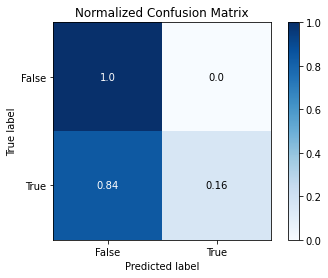

In [201]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_pred_8, normalize=True)
plt.show()

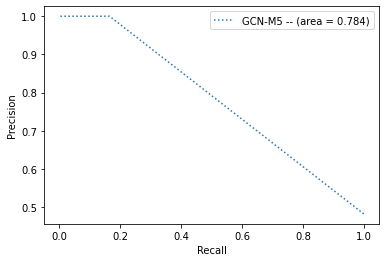

In [379]:
m5_pr, m5_re, thresholds = precision_recall_curve(y_test,y_pred_8)
pr_auc_m5=auc(m5_re, m5_pr)
pyplot.plot(m5_re, m5_pr, linestyle=':', label='GCN-M5 -- (area = %0.3f)' % pr_auc_m5)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Model-9

In [219]:
from networkx import pagerank, pagerank_numpy, pagerank_scipy
node_pagerank=pagerank(crm.network, alpha=0.85)

In [221]:
X_9 = nd.zeros((A.shape[0], 1))
for node in crm.network.nodes():
    X_9[node][0] = node_pagerank[node]
model_9, features_9 = build_model(A, X_9)
feature_representations_9= train(model_9, features_9, X_9, X_train, y_train, epochs=2000)
y_pred_9 = predict(model_9, X_9, X_test)
print(classification_report(y_test, y_pred_9))

Epoch 200/2000 -- Loss:  1.5415
[0.3104636, 0.31049526]
Epoch 400/2000 -- Loss:  1.5373
[0.31233597, 0.31174147]
Epoch 600/2000 -- Loss:  1.5309
[0.315362, 0.31398585]
Epoch 800/2000 -- Loss:  1.5215
[0.31974673, 0.3169863]
Epoch 1000/2000 -- Loss:  1.5034
[0.32670203, 0.3193221]
Epoch 1200/2000 -- Loss:  1.4424
[0.3435701, 0.3120532]
Epoch 1400/2000 -- Loss:  1.0615
[0.4424256, 0.21806104]
Epoch 1600/2000 -- Loss:  0.0283
[0.9838351, 0.011923452]
Epoch 1800/2000 -- Loss:  0.0005
[0.99954563, 3.703632e-09]
Epoch 2000/2000 -- Loss:  0.0000
[0.9999852, 1.1548198e-14]
              precision    recall  f1-score   support

       False       0.46      0.27      0.34       189
        True       0.46      0.66      0.54       176

    accuracy                           0.46       365
   macro avg       0.46      0.46      0.44       365
weighted avg       0.46      0.46      0.44       365



In [236]:
print(confusion_matrix(y_test, y_pred_9))

[[ 51 138]
 [ 60 116]]


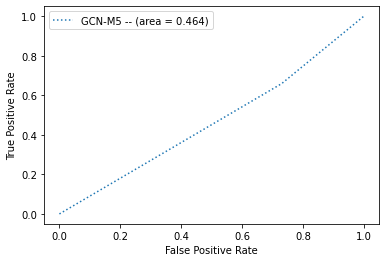

In [237]:
m6_fpr, m6_tpr, _ = roc_curve(y_test, y_pred_9)
roc_auc_m6 = roc_auc_score(y_test, y_pred_9)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m6_fpr, m6_tpr, linestyle=':', label='GCN-M5 -- (area = %0.3f)' % roc_auc_m6)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

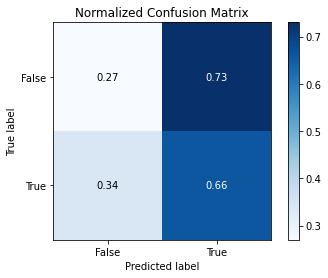

In [224]:
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_pred_9, normalize=True)
plt.show()

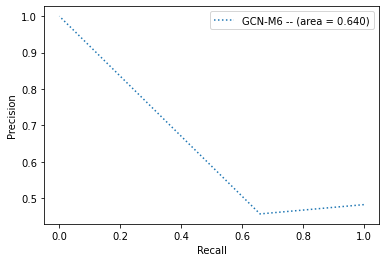

In [380]:
m6_pr, m6_re, thresholds = precision_recall_curve(y_test,y_pred_9)
pr_auc_m6=auc(m6_re, m6_pr)
pyplot.plot(m6_re, m6_pr, linestyle=':', label='GCN-M6 -- (area = %0.3f)' % pr_auc_m6)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## All features ROC - Curve

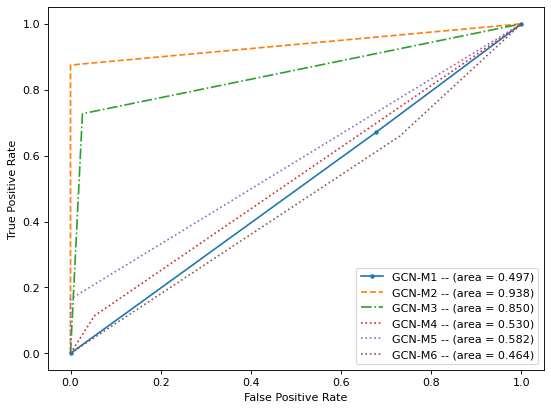

In [383]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m2_fpr, m2_tpr, linestyle='--', label='GCN-M2 -- (area = %0.3f)' % roc_auc_m2)
pyplot.plot(m3_fpr, m3_tpr, linestyle='-.', label='GCN-M3 -- (area = %0.3f)' % roc_auc_m3)
pyplot.plot(m4_fpr, m4_tpr, linestyle=':', label='GCN-M4 -- (area = %0.3f)' % roc_auc_m4)
pyplot.plot(m5_fpr, m5_tpr, linestyle=':', label='GCN-M5 -- (area = %0.3f)' % roc_auc_m5)
pyplot.plot(m6_fpr, m6_tpr, linestyle=':', label='GCN-M6 -- (area = %0.3f)' % roc_auc_m6)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## All - Models- PR curve

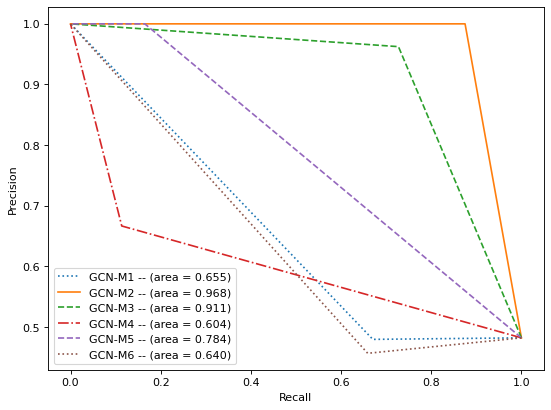

In [382]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80)

pyplot.plot(m1_re, m1_pr, linestyle=':', label='GCN-M1 -- (area = %0.3f)' % pr_auc_m1)
pyplot.plot(m2_re, m2_pr, linestyle='-', label='GCN-M2 -- (area = %0.3f)' % pr_auc_m2)
pyplot.plot(m3_re, m3_pr, linestyle='--', label='GCN-M3 -- (area = %0.3f)' % pr_auc_m3)
pyplot.plot(m4_re, m4_pr, linestyle='-.', label='GCN-M4 -- (area = %0.3f)' % pr_auc_m4)
pyplot.plot(m5_re, m5_pr, linestyle='--', label='GCN-M5 -- (area = %0.3f)' % pr_auc_m5)
pyplot.plot(m6_re, m6_pr, linestyle=':', label='GCN-M6 -- (area = %0.3f)' % pr_auc_m6)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## =====================================================================

### Model-2F

In [250]:
X_2f = nd.concat(X_9,X_1)
model_2f, features_2f = build_model(A, X_2f)
#model_4(X_4)

In [251]:
feature_representations_2f= train(model_2f, features_2f, X_2f, X_train, y_train, epochs=1000)
y_pred_2f = predict(model_2f, X_2f, X_test)
print(classification_report(y_test, y_pred_2f))

Epoch 100/1000 -- Loss:  0.7981
[0.48770365, 0.0769322]
Epoch 200/1000 -- Loss:  0.0306
[0.9829827, 0.013341677]
Epoch 300/1000 -- Loss:  0.0050
[0.99988806, 0.004894144]
Epoch 400/1000 -- Loss:  0.0017
[0.99999917, 0.0016835764]
Epoch 500/1000 -- Loss:  0.0005
[1.0, 0.0005344585]
Epoch 600/1000 -- Loss:  0.0002
[1.0, 0.0001641069]
Epoch 700/1000 -- Loss:  0.0000
[1.0, 4.9838665e-05]
Epoch 800/1000 -- Loss:  0.0000
[1.0, 1.5084819e-05]
Epoch 900/1000 -- Loss:  0.0000
[1.0, 4.5603997e-06]
Epoch 1000/1000 -- Loss:  0.0000
[1.0, 1.3786771e-06]
              precision    recall  f1-score   support

       False       0.55      0.21      0.30       189
        True       0.49      0.82      0.61       176

    accuracy                           0.50       365
   macro avg       0.52      0.51      0.46       365
weighted avg       0.52      0.50      0.45       365



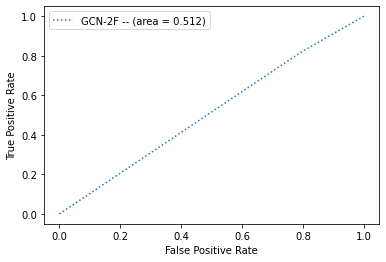

In [252]:
m2f_fpr, m2f_tpr, _ = roc_curve(y_test, y_pred_2f)
roc_auc_m2f = roc_auc_score(y_test, y_pred_2f)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m2f_fpr, m2f_tpr, linestyle=':', label='GCN-2F -- (area = %0.3f)' % roc_auc_m2f)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [253]:
print(confusion_matrix(y_test, y_pred_2f))

[[ 39 150]
 [ 32 144]]


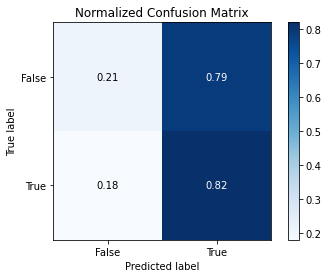

In [254]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_2f, normalize=True)
plt.show()

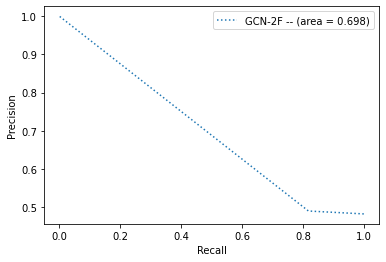

In [385]:
m2f_pr, m2f_re, thresholds = precision_recall_curve(y_test,y_pred_2f)
pr_auc_m2f=auc(m2f_re, m2f_pr)
pyplot.plot(m2f_re, m2f_pr, linestyle=':', label='GCN-2F -- (area = %0.3f)' % pr_auc_m2f)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Model-3F

In [303]:
X_3f = nd.concat(X_9,X_5,X_1)
model_3f, features_3f = build_model(A, X_3f)

In [304]:
feature_representations_3f= train(model_3f, features_3f, X_3f, X_train, y_train, epochs=1000)
y_pred_3f = predict(model_3f, X_3f, X_test)
print(classification_report(y_test, y_pred_3f))

Epoch 100/1000 -- Loss:  1.0384
[0.43975332, 0.19491638]
Epoch 200/1000 -- Loss:  0.0773
[0.962371, 0.03821472]
Epoch 300/1000 -- Loss:  0.0087
[0.9995782, 0.008213822]
Epoch 400/1000 -- Loss:  0.0012
[0.9999944, 0.0011634978]
Epoch 500/1000 -- Loss:  0.0002
[0.9999999, 0.00015023585]
Epoch 600/1000 -- Loss:  0.0000
[1.0, 1.9144649e-05]
Epoch 700/1000 -- Loss:  0.0000
[1.0, 2.435607e-06]
Epoch 800/1000 -- Loss:  0.0000
[1.0, 3.097254e-07]
Epoch 900/1000 -- Loss:  0.0000
[1.0, 3.9372974e-08]
Epoch 1000/1000 -- Loss:  0.0000
[1.0, 5.005827e-09]
              precision    recall  f1-score   support

       False       0.57      0.52      0.54       189
        True       0.53      0.57      0.55       176

    accuracy                           0.55       365
   macro avg       0.55      0.55      0.55       365
weighted avg       0.55      0.55      0.55       365



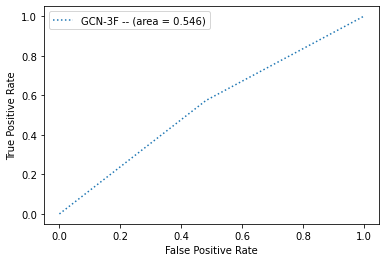

In [305]:
m3f_fpr, m3f_tpr, _ = roc_curve(y_test, y_pred_3f)
roc_auc_m3f = roc_auc_score(y_test, y_pred_3f)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m3f_fpr, m3f_tpr, linestyle=':', label='GCN-3F -- (area = %0.3f)' % roc_auc_m3f)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [308]:
print(confusion_matrix(y_test, y_pred_3f))

[[ 98  91]
 [ 75 101]]


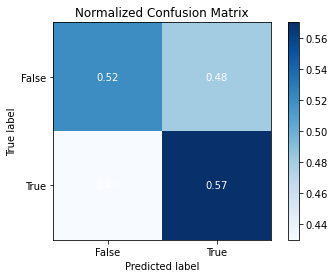

In [309]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_3f, normalize=True)
plt.show()

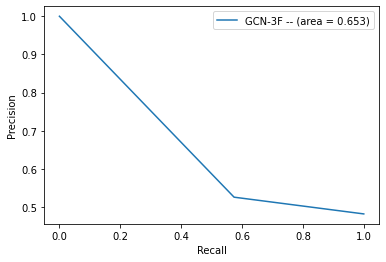

In [386]:
m3f_pr, m3f_re, thresholds = precision_recall_curve(y_test,y_pred_3f)
pr_auc_m3f=auc(m3f_re, m3f_pr)
#pyplot.plot(m2f_re, m2f_pr, linestyle=':', label='GCN-2F -- (area = %0.3f)' % pr_auc_m2f)
pyplot.plot(m3f_re, m3f_pr, linestyle='-', label='GCN-3F -- (area = %0.3f)' % pr_auc_m3f)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Model-4F

In [334]:
X_4f = nd.concat(X_9,X_5,X_8,X_1)
model_4f, features_4f = build_model(A, X_4f)

In [335]:
feature_representations_4f= train(model_4f, features_4f, X_4f, X_train, y_train, epochs=1000)
y_pred_4f = predict(model_4f, X_4f, X_test)
print(classification_report(y_test, y_pred_4f))

Epoch 100/1000 -- Loss:  1.3507
[0.3403742, 0.23886363]
Epoch 200/1000 -- Loss:  0.1935
[0.9246769, 0.1088353]
Epoch 300/1000 -- Loss:  0.0049
[0.9983681, 0.0032431353]
Epoch 400/1000 -- Loss:  0.0001
[0.99996233, 6.78199e-05]
Epoch 500/1000 -- Loss:  0.0000
[0.99999905, 1.4597966e-06]
Epoch 600/1000 -- Loss:  0.0000
[1.0, 3.15367e-08]
Epoch 700/1000 -- Loss:  0.0000
[1.0, 6.815397e-10]
Epoch 800/1000 -- Loss:  0.0000
[1.0, 1.4728982e-11]
Epoch 900/1000 -- Loss:  0.0000
[1.0, 3.1831411e-13]
Epoch 1000/1000 -- Loss:  0.0000
[1.0, 6.879218e-15]
              precision    recall  f1-score   support

       False       0.56      0.54      0.55       189
        True       0.52      0.55      0.53       176

    accuracy                           0.54       365
   macro avg       0.54      0.54      0.54       365
weighted avg       0.54      0.54      0.54       365



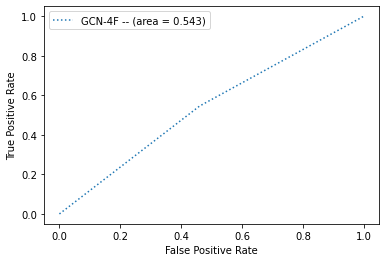

In [340]:
m4f_fpr, m4f_tpr, _ = roc_curve(y_test, y_pred_4f)
roc_auc_m4f = roc_auc_score(y_test, y_pred_4f)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m4f_fpr, m4f_tpr, linestyle=':', label='GCN-4F -- (area = %0.3f)' % roc_auc_m4f)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [337]:
print(confusion_matrix(y_test, y_pred_4f))

[[102  87]
 [ 80  96]]


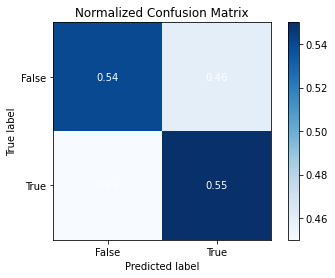

In [338]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_4f, normalize=True)
plt.show()

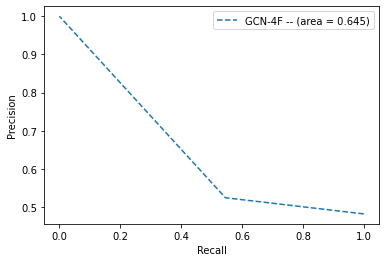

In [387]:
m4f_pr, m4f_re, thresholds = precision_recall_curve(y_test,y_pred_4f)
pr_auc_m4f=auc(m4f_re, m4f_pr)
#pyplot.plot(m2f_re, m2f_pr, linestyle=':', label='GCN-2F -- (area = %0.3f)' % pr_auc_m2f)
#pyplot.plot(m3f_re, m3f_pr, linestyle='-', label='GCN-3F -- (area = %0.3f)' % pr_auc_m3f)
pyplot.plot(m4f_re, m4f_pr, linestyle='--', label='GCN-4F -- (area = %0.3f)' % pr_auc_m4f)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Model-5F

In [355]:
X_5f = nd.concat(X_9,X_5,X_8,X_4,X_1)
model_5f, features_5f = build_model(A, X_5f)

In [356]:
feature_representations_5f= train(model_5f, features_5f, X_5f, X_train, y_train, epochs=10000)
y_pred_5f = predict(model_5f, X_5f, X_test)
print(classification_report(y_test, y_pred_5f))

Epoch 1000/10000 -- Loss:  0.0000
[1.0, 1.3839433e-13]
Epoch 2000/10000 -- Loss:  0.0000
[1.0, 1.3550132e-28]
Epoch 3000/10000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 4000/10000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 5000/10000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 6000/10000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 7000/10000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 8000/10000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 9000/10000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 10000/10000 -- Loss:  0.0000
[1.0, 0.0]
              precision    recall  f1-score   support

       False       0.55      1.00      0.71       189
        True       1.00      0.13      0.23       176

    accuracy                           0.58       365
   macro avg       0.78      0.57      0.47       365
weighted avg       0.77      0.58      0.48       365



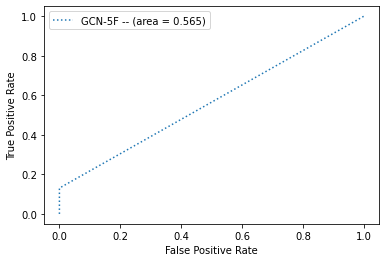

In [357]:
m5f_fpr, m5f_tpr, _ = roc_curve(y_test, y_pred_5f)
roc_auc_m5f = roc_auc_score(y_test, y_pred_5f)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m5f_fpr, m5f_tpr, linestyle=':', label='GCN-5F -- (area = %0.3f)' % roc_auc_m5f)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [358]:
print(confusion_matrix(y_test, y_pred_5f))

[[189   0]
 [153  23]]


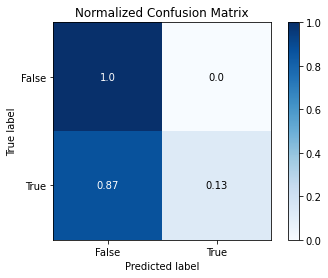

In [359]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_5f, normalize=True)
plt.show()

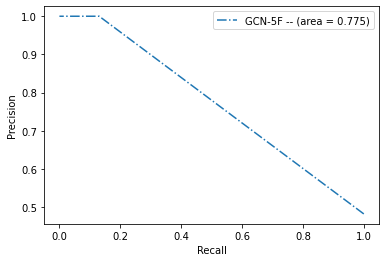

In [388]:
m5f_pr, m5f_re, thresholds = precision_recall_curve(y_test,y_pred_5f)
pr_auc_m5f=auc(m5f_re, m5f_pr)
#pyplot.plot(m2f_re, m2f_pr, linestyle=':', label='GCN-2F -- (area = %0.3f)' % pr_auc_m2f)
#pyplot.plot(m3f_re, m3f_pr, linestyle='-', label='GCN-3F -- (area = %0.3f)' % pr_auc_m3f)
#pyplot.plot(m4f_re, m4f_pr, linestyle='--', label='GCN-4F -- (area = %0.3f)' % pr_auc_m4f)
pyplot.plot(m5f_re, m5f_pr, linestyle='-.', label='GCN-5F -- (area = %0.3f)' % pr_auc_m5f)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Model-6F

In [362]:
X_6f = nd.concat(X_9,X_5,X_8,X_4,X_1,X_2)
model_6f, features_6f = build_model(A, X_6f)

In [363]:
feature_representations_6f= train(model_6f, features_6f, X_6f, X_train, y_train, epochs=1000)
y_pred_6f = predict(model_6f, X_6f, X_test)
print(classification_report(y_test, y_pred_6f))

Epoch 100/1000 -- Loss:  0.3949
[0.69450945, 0.029895619]
Epoch 200/1000 -- Loss:  0.0092
[0.9925141, 0.0016936992]
Epoch 300/1000 -- Loss:  0.0002
[0.99992836, 0.0001541579]
Epoch 400/1000 -- Loss:  0.0000
[0.9999994, 1.5026497e-05]
Epoch 500/1000 -- Loss:  0.0000
[1.0, 1.4902248e-06]
Epoch 600/1000 -- Loss:  0.0000
[1.0, 1.4837764e-07]
Epoch 700/1000 -- Loss:  0.0000
[1.0, 1.4786115e-08]
Epoch 800/1000 -- Loss:  0.0000
[1.0, 1.4735403e-09]
Epoch 900/1000 -- Loss:  0.0000
[1.0, 1.4690775e-10]
Epoch 1000/1000 -- Loss:  0.0000
[1.0, 1.464645e-11]
              precision    recall  f1-score   support

       False       0.77      1.00      0.87       189
        True       1.00      0.68      0.81       176

    accuracy                           0.85       365
   macro avg       0.89      0.84      0.84       365
weighted avg       0.88      0.85      0.84       365



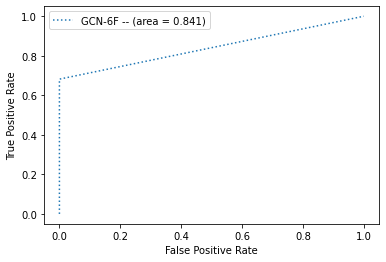

In [364]:
m6f_fpr, m6f_tpr, _ = roc_curve(y_test, y_pred_6f)
roc_auc_m6f = roc_auc_score(y_test, y_pred_6f)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m6f_fpr, m6f_tpr, linestyle=':', label='GCN-6F -- (area = %0.3f)' % roc_auc_m6f)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [365]:
print(confusion_matrix(y_test, y_pred_6f))

[[189   0]
 [ 56 120]]


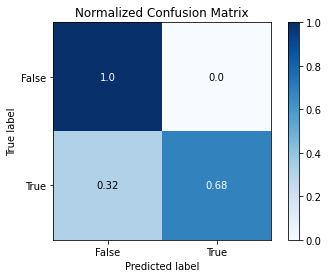

In [366]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred_6f, normalize=True)
plt.show()

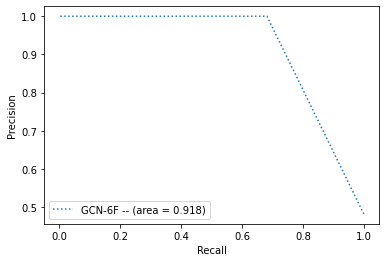

In [389]:
m6f_pr, m6f_re, thresholds = precision_recall_curve(y_test,y_pred_6f)
pr_auc_m6f=auc(m6f_re, m6f_pr)
#pyplot.plot(m2f_re, m2f_pr, linestyle=':', label='GCN-2F -- (area = %0.3f)' % pr_auc_m2f)
#pyplot.plot(m3f_re, m3f_pr, linestyle='-', label='GCN-3F -- (area = %0.3f)' % pr_auc_m3f)
#pyplot.plot(m4f_re, m4f_pr, linestyle='--', label='GCN-4F -- (area = %0.3f)' % pr_auc_m4f)
#pyplot.plot(m5f_re, m5f_pr, linestyle='-.', label='GCN-5F -- (area = %0.3f)' % pr_auc_m5f)
pyplot.plot(m6f_re, m6f_pr, linestyle=':', label='GCN-6F -- (area = %0.3f)' % pr_auc_m6f)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## ROC - Curve Feature Combination model together

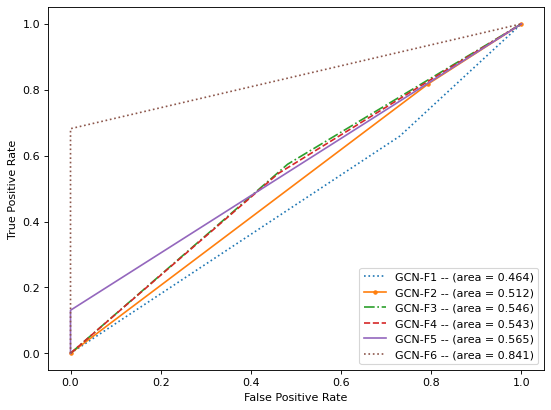

In [391]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80)
# plot the roc curve for the model
#pyplot.plot(m1_fpr, m1_tpr, marker='.', label='GCN-M1 -- (area = %0.3f)' % roc_auc_m1)
pyplot.plot(m6_fpr, m6_tpr, linestyle=':', label='GCN-F1 -- (area = %0.3f)' % roc_auc_m6)
pyplot.plot(m2f_fpr, m2f_tpr, marker='.', label='GCN-F2 -- (area = %0.3f)' % roc_auc_m2f)
pyplot.plot(m3f_fpr, m3f_tpr, linestyle='-.', label='GCN-F3 -- (area = %0.3f)' % roc_auc_m3f)
pyplot.plot(m4f_fpr, m4f_tpr, linestyle='--', label='GCN-F4 -- (area = %0.3f)' % roc_auc_m4f)
pyplot.plot(m5f_fpr, m5f_tpr, linestyle='-', label='GCN-F5 -- (area = %0.3f)' % roc_auc_m5f)
pyplot.plot(m6f_fpr, m6f_tpr, linestyle=':', label='GCN-F6 -- (area = %0.3f)' % roc_auc_m6f)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### PR - AUC curve All feature combination model

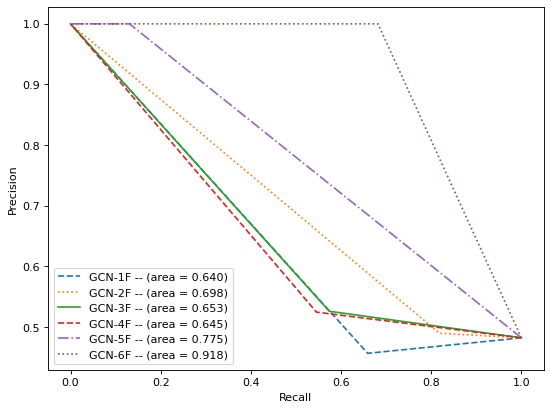

In [392]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80)
pyplot.plot(m6_re, m6_pr, linestyle='--', label='GCN-1F -- (area = %0.3f)' % pr_auc_m6)
pyplot.plot(m2f_re, m2f_pr, linestyle=':', label='GCN-2F -- (area = %0.3f)' % pr_auc_m2f)
pyplot.plot(m3f_re, m3f_pr, linestyle='-', label='GCN-3F -- (area = %0.3f)' % pr_auc_m3f)
pyplot.plot(m4f_re, m4f_pr, linestyle='--', label='GCN-4F -- (area = %0.3f)' % pr_auc_m4f)
pyplot.plot(m5f_re, m5f_pr, linestyle='-.', label='GCN-5F -- (area = %0.3f)' % pr_auc_m5f)
pyplot.plot(m6f_re, m6f_pr, linestyle=':', label='GCN-6F -- (area = %0.3f)' % pr_auc_m6f)
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### =====================================================================================

In [ ]:
#plt.plot(history.history['accuracy']) 
#plt.plot(history.history['val_accuracy']) 
#plt.title('model accuracy') 
#plt.ylabel('accuracy')
#plt.xlabel('epoch') 
#plt.legend(['train', 'test'], loc='upper left') 
#plt.show()